In [2]:
import os
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

In [3]:

# Define the base directory
base_dir = 'data_set_for_tree_health/plantvillage dataset/color'

# Get list of subdirectories (classes)
subdirs = [d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))]

# Create lists of 'healthy' and 'unhealthy' class names
healthy_classes = [d for d in subdirs if 'healthy' in d]
unhealthy_classes = [d for d in subdirs if 'healthy' not in d]

print("Healthy classes:", healthy_classes)
print("Unhealthy classes:", unhealthy_classes)

# Initialize lists to hold image paths and labels
image_paths = []
labels = []

# Map images to labels
for subdir in subdirs:
    subdir_path = os.path.join(base_dir, subdir)
    if os.path.isdir(subdir_path):
        for fname in os.listdir(subdir_path):
            fpath = os.path.join(subdir_path, fname)
            if os.path.isfile(fpath):
                image_paths.append(fpath)
                if subdir in healthy_classes:
                    labels.append(0)  # Healthy
                else:
                    labels.append(1)  # Unhealthy

# Convert lists to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

Healthy classes: ['Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___healthy', 'Grape___healthy', 'Peach___healthy', 'Pepper,_bell___healthy', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Strawberry___healthy', 'Tomato___healthy']
Unhealthy classes: ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Cherry_(including_sour)___Powdery_mildew', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Pepper,_bell___Bacterial_spot', 'Potato___Early_blight', 'Potato___Late_blight', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___S

In [4]:
# Split data into training, validation, and test sets
train_paths, temp_paths, train_labels, temp_labels = train_test_split(
    image_paths, labels, test_size=0.4, stratify=labels, random_state=42)

val_paths, test_paths, val_labels, test_labels = train_test_split(
    temp_paths, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

print(f'Training samples: {len(train_paths)}')
print(f'Validation samples: {len(val_paths)}')
print(f'Test samples: {len(test_paths)}')


Training samples: 32583
Validation samples: 10861
Test samples: 10861


In [5]:
# Define image size and batch size
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

# Preprocessing function
def preprocess_image(image_path, label):
    # Read the image from disk
    image = tf.io.read_file(image_path)
    # Decode the image
    image = tf.image.decode_jpeg(image, channels=3)
    # Resize the image
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    # Normalize the image
    image = image / 255.0
    return image, label

# Data augmentation function
def augment_image(image, label):
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_brightness(image, max_delta=0.1)
    return image, label

# Create training dataset
train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.map(augment_image, num_parallel_calls=AUTOTUNE)
train_ds = train_ds.shuffle(buffer_size=1000)
train_ds = train_ds.batch(BATCH_SIZE)
train_ds = train_ds.prefetch(AUTOTUNE)

# Create validation dataset
val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.batch(BATCH_SIZE)
val_ds = val_ds.prefetch(AUTOTUNE)

# Create test dataset
test_ds = tf.data.Dataset.from_tensor_slices((test_paths, test_labels))
test_ds = test_ds.map(preprocess_image, num_parallel_calls=AUTOTUNE)
test_ds = test_ds.batch(BATCH_SIZE)
test_ds = test_ds.prefetch(AUTOTUNE)

In [7]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, models

# Load the pre-trained MobileNetV2 model
base_model = MobileNetV2(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                         include_top=False,
                         weights='imagenet')

# Freeze the base model
base_model.trainable = False

# Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(1, activation='sigmoid')  # For binary classification
])

# Compile the model
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Display the model architecture
model.summary()


9406464/9406464 [==============================] - 2s 0us/step

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
_________________________________________________________________


In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', save_best_only=True)

# Check for class imbalance
from collections import Counter
counter = Counter(train_labels)
print("Training label distribution:", counter)

# Optionally compute class weights
from sklearn.utils import class_weight
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))
print("Class weights:", class_weights)




Training label distribution: Counter({1: 23533, 0: 9050})
Class weights: {0: 1.8001657458563536, 1: 0.6922831768155356}


In [9]:
# Train the model
history = model.fit(
    train_ds,
    epochs=20,
    validation_data=val_ds,
    class_weight=class_weights,  # Use class weights if there is class imbalance
    callbacks=[early_stopping, model_checkpoint]
)

Epoch 1/20
1019/1019 [==============================] - ETA: 0s - loss: 0.1670 - accuracy: 0.9394

C:\Users\hp\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1019/1019 [==============================] - 440s 424ms/step - loss: 0.1670 - accuracy: 0.9394 - val_loss: 0.0970 - val_accuracy: 0.9674
Epoch 2/20
1019/1019 [==============================] - 401s 393ms/step - loss: 0.0947 - accuracy: 0.9655 - val_loss: 0.0871 - val_accuracy: 0.9708
Epoch 3/20
1019/1019 [==============================] - 399s 391ms/step - loss: 0.0808 - accuracy: 0.9716 - val_loss: 0.0688 - val_accuracy: 0.9750
Epoch 4/20
1019/1019 [==============================] - 394s 386ms/step - loss: 0.0721 - accuracy: 0.9735 - val_loss: 0.0743 - val_accuracy: 0.9749
Epoch 5/20
1019/1019 [==============================] - 393s 385ms/step - loss: 0.0660 - accuracy: 0.9754 - val_loss: 0.0648 - val_accuracy: 0.9775
Epoch 6/20
1019/1019 [==============================] - 395s 387ms/step - loss: 0.0648 - accuracy: 0.9750 - val_loss: 0.0677 - val_accuracy: 0.9768
Epoch 7/20
1019/1019 [==============================] - 394s 386ms/step - loss: 0.0602 - accuracy: 0.9780 - val_loss: 0.070

340/340 [==============================] - 103s 303ms/step - loss: 0.0654 - accuracy: 0.9760
Test Accuracy: 0.98
340/340 [==============================] - 98s 287ms/step

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.94      0.97      0.96      3017
   Unhealthy       0.99      0.98      0.98      7844

    accuracy                           0.98     10861
   macro avg       0.97      0.98      0.97     10861
weighted avg       0.98      0.98      0.98     10861


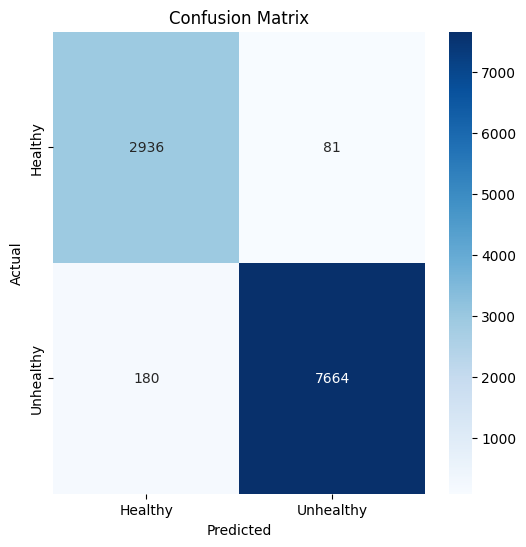

In [10]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Load the best model
model.load_weights('best_model.h5')

# Evaluate the model on the test set
test_loss, test_acc = model.evaluate(test_ds)
print(f'Test Accuracy: {test_acc:.2f}')

# Predict on the test set
y_pred_prob = model.predict(test_ds)
y_pred = np.round(y_pred_prob).astype(int).flatten()

# Get true labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)

# Classification report
print('\nClassification Report:')
print(classification_report(y_true, y_pred, target_names=['Healthy', 'Unhealthy']))

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Healthy', 'Unhealthy'],
            yticklabels=['Healthy', 'Unhealthy'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()


In [11]:


loaded_model = tf.keras.models.load_model('plant_health_model.h5')

def predict_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize(image, [IMG_HEIGHT, IMG_WIDTH])
    image = image / 255.0
    image = tf.expand_dims(image, axis=0)

    # Make prediction
    prediction = loaded_model.predict(image)
    if prediction[0][0] < 0.5:
        print("The plant is Healthy.")
    else:
        print("The plant is Unhealthy.")

predict_image('path_to_new_plant_image.jpg')


C:\Users\hp\anaconda3\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [12]:
# Unfreeze the base model
base_model.trainable = True

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all layers before 'fine_tune_at'
for layer in base_model.layers[:fine_tune_at]:
    layer.trainable = False

# Recompile the model with a lower learning rate
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Continue training
fine_tune_epochs = 10
total_epochs = len(history.history['accuracy']) + fine_tune_epochs




In [ ]:
history_fine = model.fit(
    train_ds,
    epochs=total_epochs,
    initial_epoch=history.epoch[-1],
    validation_data=val_ds,
    class_weight=class_weights,
    callbacks=[early_stopping, model_checkpoint]
)

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:

# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

In [5]:



# Define the base path to your dataset
base_path = 'data_set_for_sign_language_detection'  # Replace with your actual path

In [6]:


# Define image size and batch size
IMG_SIZE = (224, 224)  # Adjust based on your model's input size
BATCH_SIZE = 32

# Prepare image data generator for loading images
datagen = ImageDataGenerator(rescale=1./255)

# Collect images and their labels
images = []
labels = []


In [7]:

# Traverse the directory structure
for subfolder in os.listdir(base_path):
    subfolder_path = os.path.join(base_path, subfolder)
    if os.path.isdir(subfolder_path):
        for mini_folder in os.listdir(subfolder_path):
            mini_folder_path = os.path.join(subfolder_path, mini_folder)
            if os.path.isdir(mini_folder_path):
                for image_file in os.listdir(mini_folder_path):
                    image_path = os.path.join(mini_folder_path, image_file)
                    if image_file.endswith('.png'):  # Ensure it's an image file
                        # Load and preprocess the image
                        img = load_img(image_path, target_size=IMG_SIZE)
                        img_array = img_to_array(img)
                        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
                        images.append(img_array)
                        labels.append(subfolder)  # Assuming subfolder name is the label

# Convert images to a numpy array
images = np.vstack(images)

MemoryError: Unable to allocate 73.8 GiB for an array with shape (131668, 224, 224, 3) and data type float32

In [ ]:
# Make predictions
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Map predicted indices back to their corresponding labels
unique_labels = sorted(set(labels))  # Sort labels alphabetically
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}
true_labels = [label_to_index[label] for label in labels]

In [ ]:
# Calculate performance metrics
conf_matrix = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

In [ ]:
# Print performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=unique_labels))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()


In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns

# Load the trained model
model = tf.keras.models.load_model('best_model.h5')

# Define the base path to your dataset
base_path = 'data_set_for_sign_language_detection'  # Replace with your actual path

In [15]:
# Define image size and batch size
IMG_SIZE = (224, 224)  # Adjust based on your model's input size
BATCH_SIZE = 32  # Adjust based on your system's memory capacity

# Prepare the image data generator with rescaling
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
folder_to_use = 'A'

In [18]:

# Handle the dataset with potential nested subfolders and limit to 100 images per mini-folder as class
def custom_flow_from_directory(base_path, folder_to_use, IMG_SIZE, batch_size, max_images_per_class=10):
    image_list = []
    labels_list = []
    total_images = 0  # Track the total number of images
    processed_mini_folders = set()  # Keep track of unique mini-folder names

    # Process only the specified folder
    folder_path = os.path.join(base_path, folder_to_use)
    if os.path.isdir(folder_path):
        print(f"Processing folder: {folder_to_use}")  # Log the folder to be processed
        for mini_folder in os.listdir(folder_path):
            mini_folder_path = os.path.join(folder_path, mini_folder)
            if os.path.isdir(mini_folder_path):
                # Use only unique mini-folder names
                if mini_folder not in processed_mini_folders:
                    print(f"  Processing mini-folder as class: {mini_folder}")  # Log mini-folder as class
                    processed_mini_folders.add(mini_folder)  # Add to the set of processed folders
                    image_count = 0  # Reset count for each mini-folder

                    for image_file in os.listdir(mini_folder_path):
                        image_path = os.path.join(mini_folder_path, image_file)
                        if image_file.endswith('.png'):  # Modify if there are other image formats
                            if image_count >= max_images_per_class:
                                break  # Stop when we reach 100 images for this mini-folder
                            # Load and preprocess the image
                            img = tf.keras.preprocessing.image.load_img(image_path, target_size=IMG_SIZE)
                            img_array = tf.keras.preprocessing.image.img_to_array(img)
                            img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
                            img_array /= 255.0  # Rescale to [0, 1]
                            image_list.append(img_array)
                            labels_list.append(mini_folder)  # Use mini-folder as the class label
                            image_count += 1
                            total_images += 1

                            if total_images % 100 == 0:  # Print progress every 100 images
                                print(f"    Processed {total_images} images so far...")

    print(f"Total images processed from folder {folder_to_use}: {total_images}")
    return np.vstack(image_list), labels_list

# Use the custom function to handle your specific dataset structure with a limit of 100 images per mini-folder class from folder 'A'
images, labels = custom_flow_from_directory(base_path, folder_to_use, IMG_SIZE, BATCH_SIZE, max_images_per_class=10)

Processing folder: A
  Processing mini-folder as class: a
  Processing mini-folder as class: b
  Processing mini-folder as class: c
  Processing mini-folder as class: d
  Processing mini-folder as class: e
  Processing mini-folder as class: f
  Processing mini-folder as class: g
  Processing mini-folder as class: h
  Processing mini-folder as class: i
  Processing mini-folder as class: k
    Processed 100 images so far...
  Processing mini-folder as class: l
  Processing mini-folder as class: m
  Processing mini-folder as class: n
  Processing mini-folder as class: o
  Processing mini-folder as class: p
  Processing mini-folder as class: q
  Processing mini-folder as class: r
  Processing mini-folder as class: s
  Processing mini-folder as class: t
  Processing mini-folder as class: u
    Processed 200 images so far...
  Processing mini-folder as class: v
  Processing mini-folder as class: w
  Processing mini-folder as class: x
  Processing mini-folder as class: y
Total images processe

In [17]:
# Use the custom function to handle your specific dataset structure with a limit of 100 images per mini-folder class
images, labels = custom_flow_from_directory(base_path, IMG_SIZE, BATCH_SIZE, max_images_per_class=5)

TypeError: custom_flow_from_directory() missing 1 required positional argument: 'batch_size'

In [19]:
# Convert labels to numerical format
unique_labels = sorted(set(labels))  # Get unique class labels
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}  # Map labels to indices
true_labels = [label_to_index[label] for label in labels]

8/8 [==============================] - 5s 519ms/step
Accuracy: 0.0417
Precision: 0.0017
Recall: 0.0417
F1 Score: 0.0033

Classification Report:
               precision    recall  f1-score   support

           a       0.04      1.00      0.08        10
           b       0.00      0.00      0.00        10
           c       0.00      0.00      0.00        10
           d       0.00      0.00      0.00        10
           e       0.00      0.00      0.00        10
           f       0.00      0.00      0.00        10
           g       0.00      0.00      0.00        10
           h       0.00      0.00      0.00        10
           i       0.00      0.00      0.00        10
           k       0.00      0.00      0.00        10
           l       0.00      0.00      0.00        10
           m       0.00      0.00      0.00        10
           n       0.00      0.00      0.00        10
           o       0.00      0.00      0.00        10
           p       0.00      0.00      0.00 

C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\hp\anaconda3\lib\site-packages\sklearn\m

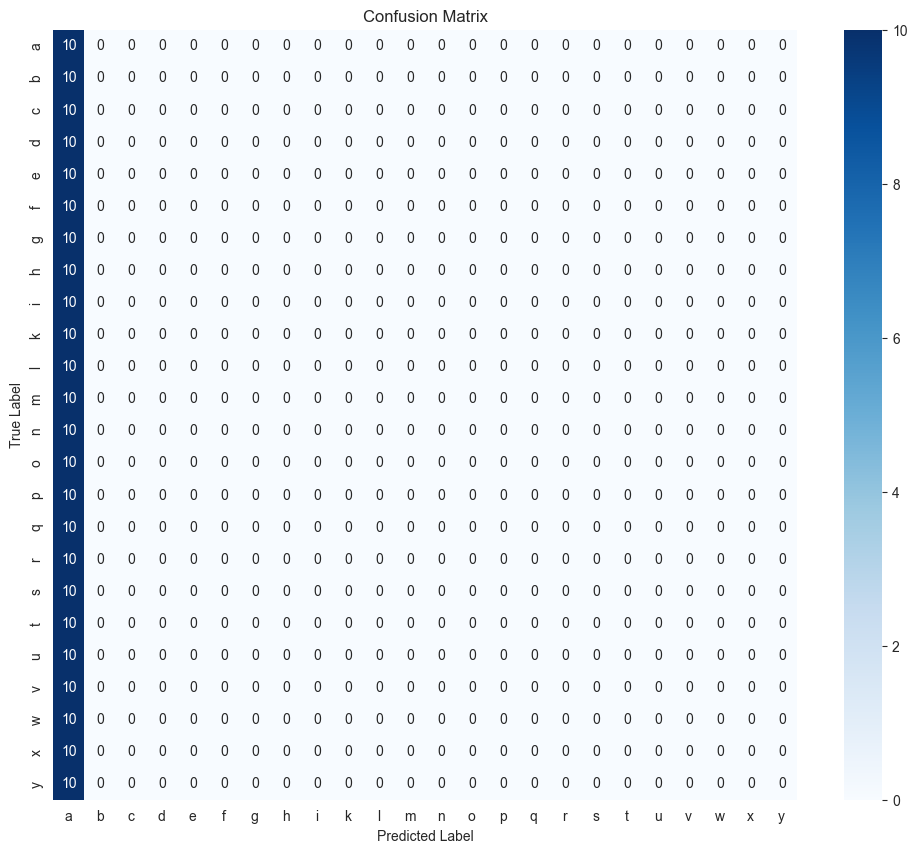

In [20]:
# Predict in batches
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Calculate performance metrics
conf_matrix = confusion_matrix(true_labels, predicted_labels)
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Print performance metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print("\nClassification Report:\n", classification_report(true_labels, predicted_labels, target_names=unique_labels))

# Plot the confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [23]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the model
model = tf.keras.models.load_model('sign_language_model_new.h5')

# Define the base path to your dataset
base_path = 'data_set_for_sign_language_detection\A'  # Replace with your actual path

# Define image size
IMG_SIZE = (224, 224)  # Adjust based on your model's input size

# Initialize lists for images and labels
images = []
labels = []

In [25]:
# Traverse the directory structure, assuming mini-folder names represent classes
for subfolder in os.listdir(base_path):
    subfolder_path = os.path.join(base_path, subfolder)
    if os.path.isdir(subfolder_path):
        for mini_folder in os.listdir(subfolder_path):
            mini_folder_path = os.path.join(subfolder_path, mini_folder)
            if os.path.isdir(mini_folder_path):
                for image_file in os.listdir(mini_folder_path):
                    if image_file.endswith('.png'):  # Modify this if you have other image formats
                        image_path = os.path.join(mini_folder_path, image_file)
                        # Load and preprocess the image
                        img = load_img(image_path, target_size=IMG_SIZE)
                        img_array = img_to_array(img)
                        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
                        img_array /= 255.0  # Rescale to [0, 1]

                        # Append image and its label (mini_folder is the class label)
                        images.append(img_array)
                        labels.append(mini_folder)  # Use mini-folder as the label

# Convert lists to arrays
images = np.vstack(images)  # Stack images into a single NumPy array

ValueError: need at least one array to concatenate

In [ ]:
# Map the class labels (mini-folder names) to numerical values
unique_labels = sorted(set(labels))  # Get unique class labels
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}  # Create mapping
true_labels = [label_to_index[label] for label in labels]  # Convert true labels to numeric

In [26]:
import os
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load the model
model = tf.keras.models.load_model('sign_language_model_new.h5')

# Define the base path to your dataset
base_path = 'data_set_for_sign_language_detection'  # Replace with your actual path

# Define image size
IMG_SIZE = (224, 224)  # Adjust based on your model's input size

# Initialize lists for images and labels
images = []
labels = []

# Dictionary to keep track of the number of images loaded per class
image_count_per_class = {}

# Traverse the directory structure, assuming mini-folder names represent classes
for subfolder in os.listdir(base_path):
    subfolder_path = os.path.join(base_path, subfolder)
    if os.path.isdir(subfolder_path):
        for mini_folder in os.listdir(subfolder_path):
            mini_folder_path = os.path.join(subfolder_path, mini_folder)
            if os.path.isdir(mini_folder_path):
                # Initialize count for this class if not already initialized
                if mini_folder not in image_count_per_class:
                    image_count_per_class[mini_folder] = 0
                
                for image_file in os.listdir(mini_folder_path):
                    if image_file.endswith('.png'):  # Modify this if you have other image formats
                        # Stop if 10 images have already been loaded for this class
                        if image_count_per_class[mini_folder] >= 10:
                            break
                        
                        image_path = os.path.join(mini_folder_path, image_file)
                        
                        # Load and preprocess the image
                        img = load_img(image_path, target_size=IMG_SIZE)
                        img_array = img_to_array(img)
                        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
                        img_array /= 255.0  # Rescale to [0, 1]

                        # Append image and its label (mini_folder is the class label)
                        images.append(img_array)
                        labels.append(mini_folder)  # Use mini-folder as the label

                        # Increment the count for this class
                        image_count_per_class[mini_folder] += 1

# Convert lists to arrays
images = np.vstack(images)  # Stack images into a single NumPy array

# Map the class labels (mini-folder names) to numerical values
unique_labels = sorted(set(labels))  # Get unique class labels
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}  # Create mapping
true_labels = [label_to_index[label] for label in labels]  # Convert true labels to numeric

# Predict using the model
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Create a DataFrame with the true and predicted labels
df = pd.DataFrame({
    'True_Label': true_labels,
    'Predicted_Label': predicted_labels
})

# Save the DataFrame as a CSV file to import into Power BI
df.to_csv('predictions.csv', index=False)

print("Predictions saved to 'predictions.csv'")


8/8 [==============================] - 2s 261ms/step
Predictions saved to 'predictions.csv'


In [28]:
# Calculate accuracy
accuracy = accuracy_score(true_labels, predicted_labels)

# Print accuracy
print(f"Accuracy: {accuracy * 100:.9f}%")

Accuracy: 99.166666667%


In [30]:


# Define image size
IMG_SIZE = (224, 224)  # Adjust based on your model's input size

# Initialize lists for images and labels
images = []
labels = []

# Dictionary to keep track of the number of images loaded per class
image_count_per_class = {}

# Traverse the directory structure, assuming mini-folder names represent classes
for subfolder in os.listdir(base_path):
    subfolder_path = os.path.join(base_path, subfolder)
    if os.path.isdir(subfolder_path):
        for mini_folder in os.listdir(subfolder_path):
            mini_folder_path = os.path.join(subfolder_path, mini_folder)
            if os.path.isdir(mini_folder_path):
                # Initialize count for this class if not already initialized
                if mini_folder not in image_count_per_class:
                    image_count_per_class[mini_folder] = 0
                
                for image_file in os.listdir(mini_folder_path):
                    if image_file.endswith('.png'):  # Modify this if you have other image formats
                        # Stop if 10 images have already been loaded for this class
                        if image_count_per_class[mini_folder] >= 10:
                            break
                        
                        image_path = os.path.join(mini_folder_path, image_file)
                        
                        # Load and preprocess the image
                        img = load_img(image_path, target_size=IMG_SIZE)
                        img_array = img_to_array(img)
                        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
                        img_array /= 255.0  # Rescale to [0, 1]

                        # Append image and its label (mini_folder is the class label)
                        images.append(img_array)
                        labels.append(mini_folder)  # Use mini-folder as the label

                        # Increment the count for this class
                        image_count_per_class[mini_folder] += 1

# Convert lists to arrays
images = np.vstack(images)  # Stack images into a single NumPy array

# Map the class labels (mini-folder names) to numerical values
unique_labels = sorted(set(labels))  # Get unique class labels
label_to_index = {label: idx for idx, label in enumerate(unique_labels)}  # Create mapping
index_to_label = {idx: label for label, idx in label_to_index.items()}  # Reverse mapping from index to label

true_labels = [label_to_index[label] for label in labels]  # Convert true labels to numeric

# Predict using the model
predictions = model.predict(images)
predicted_labels = np.argmax(predictions, axis=1)

# Convert predicted numeric labels back to class labels (letters)
predicted_class_labels = [index_to_label[pred] for pred in predicted_labels]  # Convert predicted labels to letter classes
true_class_labels = [index_to_label[true] for true in true_labels]  # Convert true labels to letter classes

# Create a DataFrame with the true and predicted labels as letter classes
df = pd.DataFrame({
    'True_Label': true_class_labels,
    'Predicted_Label': predicted_class_labels
})

# Save the DataFrame as a CSV file to import into Power BI
df.to_csv('predictions_class.csv', index=False)

print("Predictions saved to 'predictions.csv'")


8/8 [==============================] - 2s 264ms/step
Predictions saved to 'predictions.csv'
